In [110]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import RBFInterpolator
import os
from pydicom import dcmread
import math
%matplotlib inline

In [23]:
# img_path = os.path.join("Processed",os.listdir("Processed")[0])
img_path = os.path.join("Processed", "I243")
print(img_path)

Processed\I243


In [30]:
img = dcmread(img_path)

In [31]:
img = 1-(img.pixel_array-np.min(img.pixel_array))/(np.max(img.pixel_array)-np.min(img.pixel_array))
img[3095:,:] = np.zeros(img[3095:,:].shape)

In [32]:
imgqt = np.quantile(img, .05)

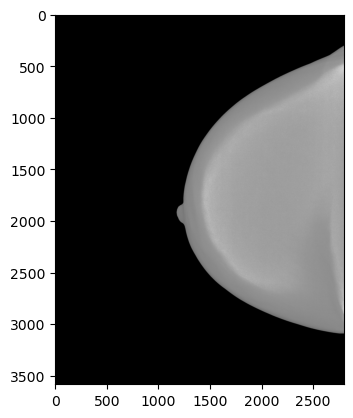

In [33]:
plt.imshow(img, cmap='gray')
plt.show()

In [34]:
R,C = img.shape
print(img.shape)

(3584, 2796)


In [35]:
# find nonzeros in each row
firsts_r = np.argmax(img>imgqt, axis=1)
# find nonzeros in each column
firsts_c = np.argmax(img>imgqt, axis=0)

In [59]:
# find first row with non-zero element 
first_row = np.argmax(firsts_r>0)
# find last row with non-zero element
last_row = R-np.argmax(firsts_r[::-1]>0)-1

In [63]:
first_rc = np.argmax(img[first_row,:]>0)
last_rc = np.argmax(img[last_row,:]>0)

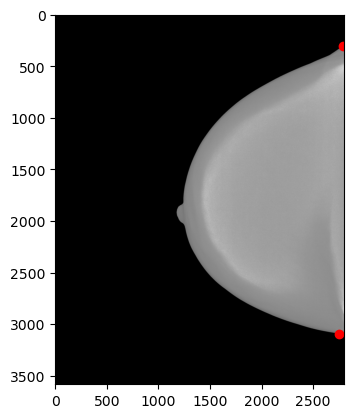

In [64]:
plt.imshow(img, cmap='gray')
plt.scatter([first_rc,last_rc], [first_row, last_row], c='r')
# plt.plot(np.linspace(0,C-1,C), np.repeat(last_row, C))
plt.show()

In [162]:
p_prev = np.array([first_rc,first_row])
coords = np.zeros((last_row-first_row,2),np.int64)
dist = 0
for y in range(last_row-first_row):
    x = np.argmax(img[first_row+y,:]>0)
    p = np.array([x,first_row+y])
    dist += np.linalg.norm(p_prev-p)
    coords[y,:] = p_prev
    p_prev = p
coords[-1,:] = p

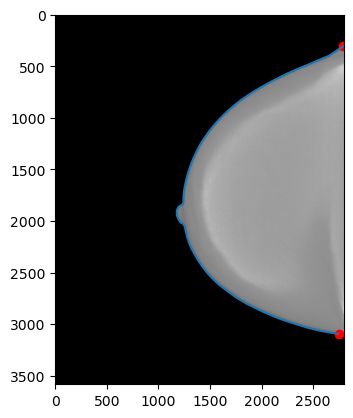

In [163]:
plt.imshow(img, cmap='gray')
plt.scatter([first_rc,last_rc], [first_row, last_row], c='r')
plt.plot(coords[:,0],coords[:,1])
plt.show()

In [202]:
x_nodes = 10
node_coords = np.zeros((x_nodes,2))
step_size = dist/(x_nodes-1)
node_coords[0,:] = coords[0,:]
node_coords[-1,:] = coords[-1,:]
node_i = 0

for coord in coords:
    if np.linalg.norm(coord-node_coords[node_i,:])<step_size:
        continue
    node_coords[node_i+1,:] = coord
    node_i += 1
    if node_i == x_nodes:
        break

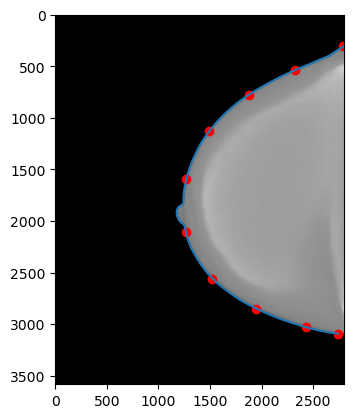

In [169]:
plt.imshow(img, cmap='gray')
plt.scatter(node_coords[:,0],node_coords[:,1], c='r')
plt.plot(coords[:,0],coords[:,1])
plt.show()

In [210]:
a = node_coords[0,:]
b = node_coords[1,:]
c = node_coords[2,:]

In [217]:
u = (a-b)/np.linalg.norm(a-b)
v = (c-b)/np.linalg.norm(c-b)
w = u+v
w = w/np.linalg.norm(w)

In [233]:
bn = np.int64(b+200*w)

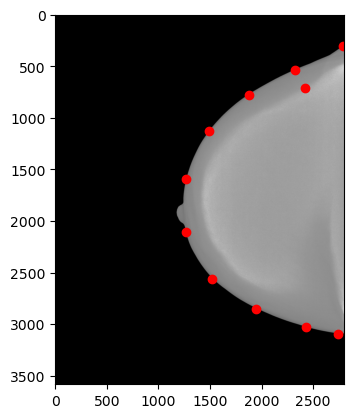

In [256]:
plt.imshow(img, cmap='gray')
plt.scatter(node_coords[:,0],node_coords[:,1], c='r')
plt.scatter(bn[0], bn[1], c='r')
plt.show()

In [290]:
node_coords2 = np.zeros(node_coords.shape)
for i in range(1,node_coords.shape[0]-1):
    u = (node_coords[i-1,:]-node_coords[i,:])
    u = u / np.linalg.norm(u)
    v = (node_coords[i+1,:]-node_coords[i,:])
    v = v / np.linalg.norm(v)
    w = u+v
    w = w / np.linalg.norm(w)
    node_coords2[i,:] = np.int64(node_coords[i]+step_size*w)

node_coords2[0,:] = node_coords[0,:]+step_size*np.array([0,1])
node_coords2[-1,:] = node_coords[-1,:]-step_size*np.array([0,1])

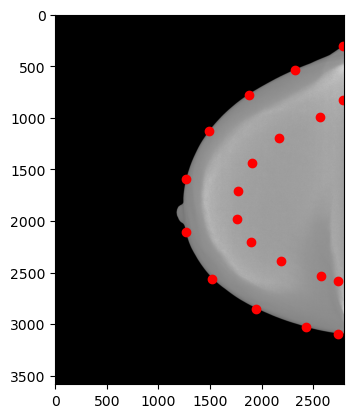

In [291]:
plt.imshow(img, cmap='gray')
plt.scatter(node_coords[:,0],node_coords[:,1], c='r')
plt.scatter(node_coords2[:,0], node_coords2[:,1], c='r')
plt.show()